<a href="https://colab.research.google.com/github/astroChance/RadNET/blob/black_white/RadNET_Model_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Altering for single-channel B&W images

In [ ]:
"""
Model based on Pix2Pix structure

utilizes Unet generator with skip connections

pix2pix tutorial (Unet generator example)  https://www.tensorflow.org/tutorials/generative/pix2pix

"""

# Library Imports and Data Access

In [1]:
import tensorflow as tf

import os
import shutil
import time
import datetime
from matplotlib import pyplot as plt
import numpy as np
import gc

from IPython import display
from PIL import Image


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## GPU / TPU checks

In [ ]:
## Test that GPU is enabled

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
## Initialize TPU

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))


In [ ]:
## Check available memory

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
## Check GPU memory

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

# Download data to local VM

In [3]:
## Use gdown to copy zip files to local VM
## Unpack zip files on local VM

## Only use set 1 or set 2, each is 20k images
# Set 1
!gdown --id 1V_RDJIf8hQbmbznrkVwv197MDfHGB8Gu
!gdown --id 1eO_rHzznTZukW0J6wFdRgIuYyhqP6eis

_2D_folder_local = '/content/2D_Production_Min12_Max1_Training_BWSet1.zip'

_3D_folder_local = '/content/3D_Production_Min12_Max1_Training_BWSet1.zip'

target_dir = '/content'
shutil.unpack_archive(_2D_folder_local, target_dir)
shutil.unpack_archive(_3D_folder_local, target_dir)

# Set 2
!gdown --id 1ToulzcGXOwyb3vkRCx1X0Vj7Dx04JTwL
!gdown --id 1N-7aImVlvvi-gLo42ryYnAlTUNKeIHST

_2D_folder_local = '/content/2D_Production_Min12_Max1_Training_BWSet2.zip'

_3D_folder_local = '/content/3D_Production_Min12_Max1_Training_BWSet2.zip'

target_dir = '/content'
shutil.unpack_archive(_2D_folder_local, target_dir)
shutil.unpack_archive(_3D_folder_local, target_dir)

# Print sizes of training directories
total = 0
for path, dirs, files in os.walk(_2D_folder_local.split('.')[0]):
    for f in files:
        fp = os.path.join(path, f)
        total += os.path.getsize(fp)
print("Size of 2D directory: ", (total/1000000), "MB")

total = 0
for path, dirs, files in os.walk(_3D_folder_local.split('.')[0]):
    for f in files:
        fp = os.path.join(path, f)
        total += os.path.getsize(fp)
print("Size of 3D directory: ", (total/1000000), "MB")


## Links to zip files on Drive
# 2D Set 1 zip
# https://drive.google.com/file/d/1V_RDJIf8hQbmbznrkVwv197MDfHGB8Gu/view?usp=sharing
# 2D Set 2 zip
# https://drive.google.com/file/d/1ToulzcGXOwyb3vkRCx1X0Vj7Dx04JTwL/view?usp=sharing

# 3D Set 1 zip
# https://drive.google.com/file/d/1eO_rHzznTZukW0J6wFdRgIuYyhqP6eis/view?usp=sharing
# 3D Set 2 zip
# https://drive.google.com/file/d/1N-7aImVlvvi-gLo42ryYnAlTUNKeIHST/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1V_RDJIf8hQbmbznrkVwv197MDfHGB8Gu
To: /content/2D_Production_Min12_Max1_Training_BWSet1.zip
108MB [00:01, 92.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eO_rHzznTZukW0J6wFdRgIuYyhqP6eis
To: /content/3D_Production_Min12_Max1_Training_BWSet1.zip
108MB [00:01, 101MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1ToulzcGXOwyb3vkRCx1X0Vj7Dx04JTwL
To: /content/2D_Production_Min12_Max1_Training_BWSet2.zip
108MB [00:01, 81.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1N-7aImVlvvi-gLo42ryYnAlTUNKeIHST
To: /content/3D_Production_Min12_Max1_Training_BWSet2.zip
108MB [00:01, 88.6MB/s]
Size of 2D directory:  118.999641 MB
Size of 3D directory:  118.25319 MB


# Data Preparation

In [4]:
## Define local VM paths to image files

set_1_or_2 = 1  # define if using set 1 or set 2, 20k images each

if set_1_or_2 == 1:
  _2D_imgs_path = '/content/2D_Production_Min12_Max1_Training_BWSet1'
  _3D_imgs_path = '/content/3D_Production_Min12_Max1_Training_BWSet1'
elif set_1_or_2 == 2:
  _2D_imgs_path = '/content/2D_Production_Min12_Max1_Training_BWSet2'
  _3D_imgs_path = '/content/3D_Production_Min12_Max1_Training_BWSet2'


start = time.time()
## Iterate through folders, create list of filepaths for images
TwoDImages = []
for root, dirs, files in os.walk(_2D_imgs_path):
      for name in files:
          if name.endswith(".png"):
              filename = os.path.join(root, name)
              TwoDImages.append(filename)

ThreeDImages = []
for root, dirs, files in os.walk(_3D_imgs_path):
      for name in files:
          if name.endswith(".png"):
              filename = os.path.join(root, name)
              ThreeDImages.append(filename)

TwoDImages = sorted(TwoDImages, key=lambda x: int(x.split('/')[-1].split('_')[0]))
ThreeDImages = sorted(ThreeDImages, key=lambda x: int(x.split('/')[-1].split('_')[0]))

# Deleted subsetting of images, trying to fit all 20k
# black and white images into memory

end = time.time()
print("Time to completion (s): ", end-start)

Time to completion (s):  0.15360212326049805


In [5]:
## Check size of file lists, check that trace pair number (leading digits)
## is same between 2D and 3D file

print(len(TwoDImages))
print(len(ThreeDImages))
print(TwoDImages[-1])
print(ThreeDImages[-1])

20000
20000
/content/2D_Production_Min12_Max1_Training_BWSet1/19999_2090401000_2D_238.png
/content/3D_Production_Min12_Max1_Training_BWSet1/19999_2090401000_3D_217121.png


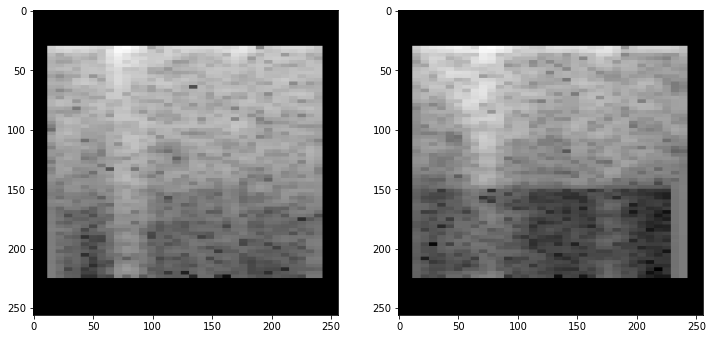

In [18]:
## Visual QC of image files
## Scaled same as model ingestion

idx_to_plot = -1

image_2D = TwoDImages[idx_to_plot]
image_3D = ThreeDImages[idx_to_plot]

with Image.open(image_2D) as img:
    img = np.array(img)
    img=img[:,:,:1]  # only take first channel of B&W image
    img2d=np.squeeze((img / 127.5) - 1)
with Image.open(image_3D) as img:
    img = np.array(img)
    img=img[:,:,:1]  # only take first channel of B&W image
    img3d=np.squeeze((img / 127.5) - 1)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (12,8))
ax[0].imshow(img2d, cmap = 'binary')
ax[1].imshow(img3d, cmap = 'binary')
plt.show()

In [6]:
######
# Create TensorFLow Dataset from images
######

## Parameters used throughout Preparation and Model Build
BATCH_SIZE = 64
IMG_SIZE0 = 256    # Initial model implementation only works with 256x256 - revisit up/down layers for other sizes
IMG_SIZE1 = 256
OUTPUT_CHANNELS = 1  # changing to one channel for B&W images


start = time.time()

tr_data3d = np.zeros((len(ThreeDImages), IMG_SIZE0, IMG_SIZE1, OUTPUT_CHANNELS), dtype=np.float32)
counter = 0
for image in ThreeDImages:
  with Image.open(image) as img:
    img = np.array(img)
    img=img[:,:,:1]  # only take first channel of B&W image
    img=(img / 127.5) - 1
    tr_data3d[counter] = img
    del img
    counter += 1

tr_data2d = np.zeros((len(TwoDImages), IMG_SIZE0, IMG_SIZE1, OUTPUT_CHANNELS), dtype=np.float32)
counter = 0
for image in TwoDImages:
  with Image.open(image) as img:
    img = np.array(img)
    img=img[:,:,:1]   # only take first channel of B&W image
    img=(img / 127.5) - 1
    tr_data2d[counter] = img
    del img
    counter += 1

data_tf_2D = tf.convert_to_tensor(tr_data2d, np.float32)
data_tf_3D = tf.convert_to_tensor(tr_data3d, np.float32)
del tr_data2d
del tr_data3d

train_dataset2d_0 = tf.data.Dataset.from_tensor_slices(data_tf_2D)
train_dataset2d = train_dataset2d_0.batch(BATCH_SIZE)

train_dataset3d_0 = tf.data.Dataset.from_tensor_slices(data_tf_3D)
train_dataset3d = train_dataset3d_0.batch(BATCH_SIZE)

gc.collect()

end = time.time()
print("Time to completion (s): ", end-start)

Time to completion (s):  63.73155665397644


# Define Deep Learning Model Architecture

In [7]:
# Define discriminator and generator models
# Define loss and optimizers
# Instantiate models

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result



def Generator():
  inputs = tf.keras.layers.Input(shape=[IMG_SIZE0, IMG_SIZE1, OUTPUT_CHANNELS])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)



def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[IMG_SIZE0, IMG_SIZE1, OUTPUT_CHANNELS], name='input_image')
  tar = tf.keras.layers.Input(shape=[IMG_SIZE0, IMG_SIZE1, OUTPUT_CHANNELS], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


# define loss and optimizers

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss



generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


# Instantiate the models  (toggle on for GPU)
generator = Generator()
discriminator = Discriminator()

In [ ]:
#################
#### ENABLE TPU VERSION OF MODEL

#### ONLY USE WITH TPU

strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
  generator = Generator()
  discriminator = Discriminator()

# TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']

# generator = tf.contrib.tpu.keras_to_tpu_model(
#     generator,
#     strategy=tf.contrib.tpu.TPUDistributionStrategy(
#         tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

# discriminator = tf.contrib.tpu.keras_to_tpu_model(
#     discriminator,
#     strategy=tf.contrib.tpu.TPUDistributionStrategy(
#         tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

In [ ]:
## Display graphical model description

# Generator().summary()
# Discriminator().summary()

tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
# tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

# Define Training Steps and Checkpoints

In [8]:
# set up checkpoints and define training / fit steps

log_dir="/content/drive/My Drive/RadNET/logs/Production_Run2"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

checkpoint_dir = '/content/drive/My Drive/RadNET/training_checkpoints/Production_Run2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))



  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)



def fit(train_3d, train_2d, epochs, chkpt_save):
    for epoch in range(epochs):
        display.clear_output(wait=True)
        try:
            print ('Time taken for epoch {} was {} sec\n'.format(epoch - 1,
                                                        time.time()-start))
        except:
            pass

        start = time.time()
        print("Epoch ", epoch, " running...")

        n=0
        # Train (separate Datasets for input and target)
        for input_image, target in tf.data.Dataset.zip((train_3d, train_2d)):
            train_step(input_image, target, epoch)
            if (n+1) % 100 == 0:
                print('.', end='')
            n +=1 
    
        print()

        


    # saving (checkpoint) the model every chkpt_save epochs
        if (epoch + 1) % chkpt_save == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    checkpoint.save(file_prefix = checkpoint_prefix)

# Train the Model

In [ ]:
# Load latest checkpoint if picking up / continuing training 
# Skip if starting from scratch

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Launch Tensorboard to monitor progress

%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [11]:
# Define how many epochs to run model
EPOCHS = 39
chkpt_save = 20

# Run the model
fit(train_dataset3d, train_dataset2d, EPOCHS, chkpt_save)

print("Training Complete!")

Time taken for epoch 37 was 149.5414342880249 sec

Epoch  38  running...
...
Training Complete!


# Run Predictions on Test Dataset

In [13]:
### Use gdown to copy zip files to local VM
## Unpack zip files on local VM
  
!gdown --id 1cYpHpNFLKN_Ojei9vnMGeJOCNnLbYYkx

_3D_Test_folder_local = '/content/3D_Production_Min12_Max1_Testing.zip'

target_dir = '/content'
shutil.unpack_archive(_3D_Test_folder_local, target_dir)

## Link to zip file on Drive
# 3D
# https://drive.google.com/file/d/1cYpHpNFLKN_Ojei9vnMGeJOCNnLbYYkx/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1JE76ICdBm4jXUBTO6Gnlp73m17cWWtuZ
To: /content/2D_Production_Min12_Max1_Testing.zip
2.68MB [00:00, 136MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cYpHpNFLKN_Ojei9vnMGeJOCNnLbYYkx
To: /content/3D_Production_Min12_Max1_Testing.zip
2.69MB [00:00, 85.0MB/s]


In [24]:
# Run GAN Frequency Enhancement on 3D test images

## local VM data:
_3D_test_path = '/content/3D_Production_Min12_Max1_Testing'

output_prediction_path = "/content/drive/My Drive/RadNET/GAN data/Production_Run2_BW/Predictions_v122320_lowEpochs/"



TestImages = []
for root, dirs, files in os.walk(_3D_test_path):
    for name in files:
        if name.endswith(".png"):
            filename = os.path.join(root, name)
            name = name.split('.')[0]
            TestImages.append([name, filename])

## Make sure these parameters match image generation step
colormap = 'binary'
min_val = -12
max_val = 1
shading = 'flat'

for image in TestImages:
    with Image.open(image[1]) as img:
      img = np.array(img)
      img=img[:,:,:1]
      img=(img / 127.5) - 1
      testing = np.expand_dims(img, axis=0)
      model_test = generator.predict(testing)
      model_test = np.squeeze(model_test)
      model_test = (model_test + 1) * 127.5
      model_test = model_test.astype(np.uint8)
      plt.imsave(os.path.join(output_prediction_path,str(image[0]) + "_prediction.png"), 
                model_test, cmap=colormap, vmin=min_val, vmax=max_val)
    



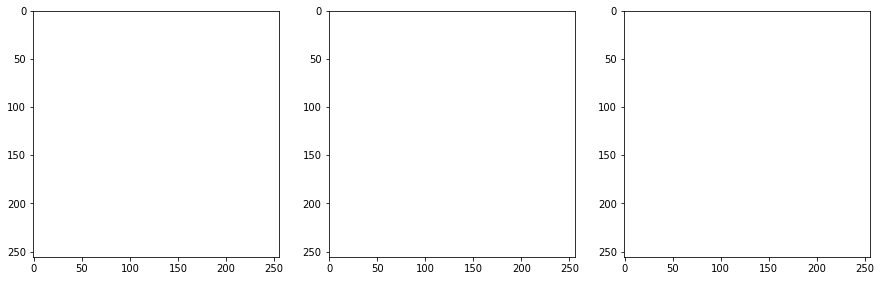

In [31]:
## QC of output image files

idxs_to_plot = [0, int(len(TestImages)/2), -1]

img1 = os.path.join(output_prediction_path,str(TestImages[idxs_to_plot[0]][0]) + "_prediction.png")
img2 = os.path.join(output_prediction_path,str(TestImages[idxs_to_plot[1]][0]) + "_prediction.png")
img3 = os.path.join(output_prediction_path,str(TestImages[idxs_to_plot[2]][0]) + "_prediction.png")


with Image.open(img1) as img:
    img = np.array(img)
    img=img[:,:,1]  # only take first channel of B&W image
    img1=np.squeeze((img / 127.5) - 1)
with Image.open(img2) as img:
    img = np.array(img)
    img=img[:,:,:1]  # only take first channel of B&W image
    img2=np.squeeze((img / 127.5) - 1)
with Image.open(img3) as img:
    img = np.array(img)
    img=img[:,:,:1]  # only take first channel of B&W image
    img3=np.squeeze((img / 127.5) - 1)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (15,8))
ax[0].imshow(img1, cmap = 'binary')
ax[1].imshow(img2, cmap = 'binary')
ax[2].imshow(img3, cmap = 'binary')
plt.show()